In [1]:
import os
import pandas as pd
import empyrical as empy

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
def show_cum_ret(ret):
    fig, ax = plt.subplots(figsize=(20,10))
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = ret.shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    (1+ret).cumprod().plot(ax=ax)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()

def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        #print('i', i)
        #print('j', j)
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.dropna().iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()

def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [
        total_return, 
        lambda x: empy.annual_return(x), 
        lambda x: empy.sharpe_ratio(x), 
        lambda x: empy.annual_volatility(x), 
        lambda x: empy.max_drawdown(x), 
        avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    #buy01 = ret.apply(lambda x: 0 if x==0 else 1)
    #se['buy_ratio'] = buy01.mean()
    #se['flip_ratio'] = (buy01-buy01.shift()).abs().mean()
    
    return se

def calculation_score(df):
    df['Sharpe Score'] = df['sharpe_ratio'].apply(lambda x: x if x>0 else 0) * 100
    df['Return Score'] = df['annual_return'].apply(lambda x: 1+x/2) * 100
    df['Max-DD Score'] = df['max_drawdown'].apply(lambda x: 1+x) * 100
    df['Avg-DD Score'] = df['avg_drawdown'].apply(lambda x: 1+x) * 100
    client_weight = {'sharpe_ratio':1,'annual_return':1, 'max_drawdown':1, 'avg_drawdown':1}
    df['Total Score'] = 0
    for score, weight in client_weight.items():
        df['Total Score'] += weight * df[score]
    df.index.name = 'case'
    return df

In [3]:
algo_folder = './pc0/pca_result/'
algo_name = 'pca'

In [4]:
def formatting_casename(casename):
    if casename.startswith('Nequities'):
        casename = casename.replace('Nequities', 'lb30N')
    elif casename.startswith('lb') and 'N' not in casename:
        casename = casename + 'N30'
    else:
        pass

    lb = casename.split('lb')

In [5]:
algo_price = pd.DataFrame()
algo_ratio = {}
for f in os.listdir(algo_folder):
    if not f.endswith('.csv'):
        continue
    if not f.startswith(algo_name):
        continue

    if f.startswith('{}_price'.format(algo_name)):
        casename = f.replace('{}_price_'.format(algo_name), "").replace('.csv', "")
        if casename.startswith('benchmark'):
            casename = casename.replace('benchmark', 'lb252N30')
        elif casename.startswith('Nequities'):
            casename = casename.replace('Nequities', 'lb252N')
        elif casename.startswith('lb') and 'N' not in casename:
            casename = casename + 'N30'

        df = pd.read_csv(os.path.join(algo_folder, f), index_col='date')
        df.index = pd.to_datetime(df.index).date
        df = df.sort_index()
        algo_price[casename] = df['adj_close']

    elif f.startswith('{}_ratio'.format(algo_name)):
        casename = f.replace('{}_ratio_'.format(algo_name), "").replace('.csv', "")
        df = pd.read_csv(os.path.join(algo_folder, f))
        df = pd.pivot_table(df, columns='code', index='date', values='ratio')
        df.index = pd.to_datetime(df.index).date
        df = df.sort_index()
        algo_ratio[casename] = df
    else:
        pass

In [6]:
algo_price.to_csv('./algo_price.csv')

In [11]:
returns = algo_price.pct_change()

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score
case,,,,,,,,,,,,,
lb126N30,4.4719,0.141702,0.695404,0.228209,-0.424083,-0.056477,0.334138,2.509026,69.540412,107.085112,57.591742,94.352300,0.356547
lb10N30,3.5460,0.125319,0.682460,0.203531,-0.384413,-0.048021,0.326000,2.609686,68.246035,106.265938,61.558704,95.197937,0.375346
lb10N20,3.6312,0.126949,0.674938,0.209908,-0.400332,-0.051605,0.317110,2.460022,67.493828,106.347458,59.966800,94.839512,0.349951
lb50N15,4.5246,0.142556,0.668935,0.243939,-0.461583,-0.063053,0.308841,2.260886,66.893541,107.127790,53.841732,93.694694,0.286855
lb252N10,4.9998,0.149930,0.659172,0.265670,-0.459591,-0.078471,0.326226,1.910654,65.917216,107.496520,54.040881,92.152928,0.271041
lb252N20,4.3021,0.138900,0.657095,0.243091,-0.442523,-0.061964,0.313881,2.241614,65.709476,106.944977,55.747723,93.803593,0.291507
lb252N30,3.9480,0.132778,0.656691,0.230517,-0.420268,-0.058840,0.315937,2.256614,65.669096,106.638911,57.973217,94.116042,0.310362
lb63N30,3.7453,0.129090,0.652132,0.225394,-0.451448,-0.058973,0.285946,2.188967,65.213215,106.454489,54.855228,94.102706,0.270801
lb252N5,5.0672,0.150932,0.641435,0.280720,-0.488462,-0.085455,0.308995,1.766217,64.143484,107.546622,51.153822,91.454478,0.218450


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score
case,,,,,,,,,,,,,
lb252N5,5.0672,0.150932,0.641435,0.280720,-0.488462,-0.085455,0.308995,1.766217,64.143484,107.546622,51.153822,91.454478,0.218450
lb252N10,4.9998,0.149930,0.659172,0.265670,-0.459591,-0.078471,0.326226,1.910654,65.917216,107.496520,54.040881,92.152928,0.271041
lb50N15,4.5246,0.142556,0.668935,0.243939,-0.461583,-0.063053,0.308841,2.260886,66.893541,107.127790,53.841732,93.694694,0.286855
lb126N30,4.4719,0.141702,0.695404,0.228209,-0.424083,-0.056477,0.334138,2.509026,69.540412,107.085112,57.591742,94.352300,0.356547
lb252N15,4.3089,0.139013,0.640806,0.253432,-0.463567,-0.069101,0.299878,2.011746,64.080630,106.950668,53.643302,93.089915,0.247152
lb252N20,4.3021,0.138900,0.657095,0.243091,-0.442523,-0.061964,0.313881,2.241614,65.709476,106.944977,55.747723,93.803593,0.291507
lb50N10,4.2031,0.137227,0.632419,0.254957,-0.466478,-0.068202,0.294177,2.012067,63.241890,106.861352,53.352181,93.179797,0.234966
lb252N30,3.9480,0.132778,0.656691,0.230517,-0.420268,-0.058840,0.315937,2.256614,65.669096,106.638911,57.973217,94.116042,0.310362
lb63N30,3.7453,0.129090,0.652132,0.225394,-0.451448,-0.058973,0.285946,2.188967,65.213215,106.454489,54.855228,94.102706,0.270801


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score
case,,,,,,,,,,,,,
lb10N30,3.5460,0.125319,0.682460,0.203531,-0.384413,-0.048021,0.326000,2.609686,68.246035,106.265938,61.558704,95.197937,0.375346
lb126N30,4.4719,0.141702,0.695404,0.228209,-0.424083,-0.056477,0.334138,2.509026,69.540412,107.085112,57.591742,94.352300,0.356547
lb10N20,3.6312,0.126949,0.674938,0.209908,-0.400332,-0.051605,0.317110,2.460022,67.493828,106.347458,59.966800,94.839512,0.349951
lb252N30,3.9480,0.132778,0.656691,0.230517,-0.420268,-0.058840,0.315937,2.256614,65.669096,106.638911,57.973217,94.116042,0.310362
lb252N20,4.3021,0.138900,0.657095,0.243091,-0.442523,-0.061964,0.313881,2.241614,65.709476,106.944977,55.747723,93.803593,0.291507
lb50N15,4.5246,0.142556,0.668935,0.243939,-0.461583,-0.063053,0.308841,2.260886,66.893541,107.127790,53.841732,93.694694,0.286855
lb252N10,4.9998,0.149930,0.659172,0.265670,-0.459591,-0.078471,0.326226,1.910654,65.917216,107.496520,54.040881,92.152928,0.271041
lb63N30,3.7453,0.129090,0.652132,0.225394,-0.451448,-0.058973,0.285946,2.188967,65.213215,106.454489,54.855228,94.102706,0.270801
lb10N15,3.1188,0.116693,0.621344,0.215047,-0.423228,-0.058387,0.275722,1.998619,62.134413,105.834658,57.677217,94.161310,0.256423


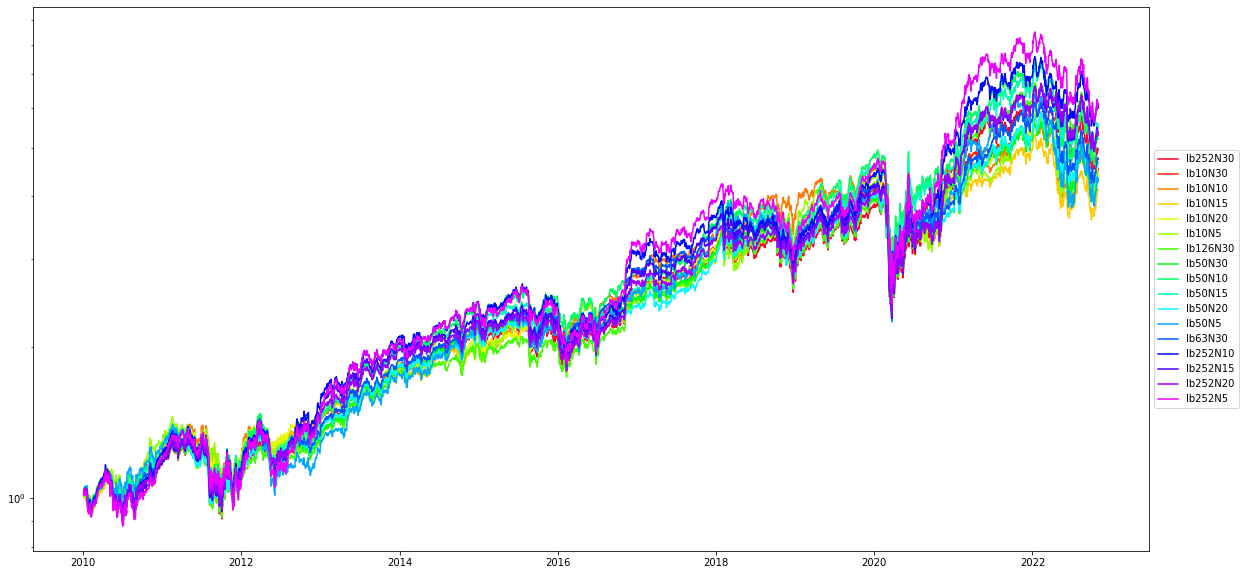

In [12]:
met = empy_metric(returns)
met = calculation_score(met)
display(met.sort_values("sharpe_ratio", ascending=False))
display(met.sort_values("annual_return", ascending=False))
display(met.sort_values("Total Score", ascending=False))
show_cum_ret(returns)

In [11]:
# regenerate backtest_17etfs.csv

backtest_price = pd.read_csv('backtest_17etfs.csv', index_col=0)
backtest_price = backtest_price[backtest_price['code'] != 'PC0']
backtest_price


,date,code,open,high,low,close,adj_open,adj_high,adj_low,adj_close
0,1993-01-29,SPY,43.968750,43.968750,43.750000,43.93750,25.352035,25.352035,25.225906,25.334017
1,1993-02-01,SPY,43.968750,44.250000,43.968750,44.25000,25.352043,25.514210,25.352043,25.514210
2,1993-02-02,SPY,44.218750,44.375000,44.125000,44.34375,25.496192,25.586284,25.442136,25.568266
3,1993-02-03,SPY,44.406250,44.843750,44.375000,44.81250,25.604304,25.856563,25.586286,25.838545
4,1993-02-04,SPY,44.968750,45.093750,44.468750,45.00000,25.928635,26.000709,25.640339,25.946653
...,...,...,...,...,...,...,...,...,...,...
82818,2022-12-06,OSP,NaN,343.290000,343.290000,343.29000,NaN,NaN,NaN,343.290000
82819,2022-12-06,VGK,56.889999,57.014999,56.310001,56.52000,56.889999,57.014999,56.310001,56.520000
82820,2022-12-06,EWJ,54.900002,55.064999,54.355000,54.59000,54.900002,55.064999,54.355000,54.590000
82821,2022-12-06,LQD,108.870003,108.974998,108.529999,108.82000,108.870003,108.974998,108.529999,108.820000


In [20]:
# algo_price
for col in algo_price.columns:
    # new_price = backtest_price.copy()
    ser = algo_price[col]
    df = pd.concat([ser]*4, axis=1)
    df.columns = ['high', 'low', 'close', 'adj_close']
    df.insert(0, 'code', 'PC0')
    df.index.name = 'date'
    df = df.reset_index(drop=False)
    
    new_price = pd.concat([backtest_price, df])
    new_price = new_price.reset_index(drop=True)
    print(new_price)

    new_price_path = './pc0/backtest_price/backtest_17etfs_{}.csv'.format(col)
    new_price.to_csv(new_price_path)
    # break

             date code      open       high        low      close   adj_open  \
0      1993-01-29  SPY  43.96875   43.96875   43.75000   43.93750  25.352035   
1      1993-02-01  SPY  43.96875   44.25000   43.96875   44.25000  25.352043   
2      1993-02-02  SPY  44.21875   44.37500   44.12500   44.34375  25.496192   
3      1993-02-03  SPY  44.40625   44.84375   44.37500   44.81250  25.604304   
4      1993-02-04  SPY  44.96875   45.09375   44.46875   45.00000  25.928635   
...           ...  ...       ...        ...        ...        ...        ...   
82794  2022-10-26  PC0       NaN  489.76000  489.76000  489.76000        NaN   
82795  2022-10-27  PC0       NaN  487.69000  487.69000  487.69000        NaN   
82796  2022-10-28  PC0       NaN  499.67000  499.67000  499.67000        NaN   
82797  2022-10-31  PC0       NaN  495.43000  495.43000  495.43000        NaN   
82798  2022-11-01  PC0       NaN  494.80000  494.80000  494.80000        NaN   

        adj_high    adj_low   adj_close

In [53]:
case_dict = {
    'lb': [10, 50, 63, 126, 252], 
    'N': [5, 10, 15, 20, 30]
}

cols = ['lb252N30']
# sortby = 'return/avgdd'

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score
case,,,,,,,,,,,,,
lb252N10,4.9998,0.149930,0.659172,0.265670,-0.459591,-0.078471,0.326226,1.910654,65.917216,107.496520,54.040881,92.152928,0.271041
lb252N20,4.3021,0.138900,0.657095,0.243091,-0.442523,-0.061964,0.313881,2.241614,65.709476,106.944977,55.747723,93.803593,0.291507
lb252N30,3.9480,0.132778,0.656691,0.230517,-0.420268,-0.058840,0.315937,2.256614,65.669096,106.638911,57.973217,94.116042,0.310362
lb252N5,5.0672,0.150932,0.641435,0.280720,-0.488462,-0.085455,0.308995,1.766217,64.143484,107.546622,51.153822,91.454478,0.218450
lb252N15,4.3089,0.139013,0.640806,0.253432,-0.463567,-0.069101,0.299878,2.011746,64.080630,106.950668,53.643302,93.089915,0.247152


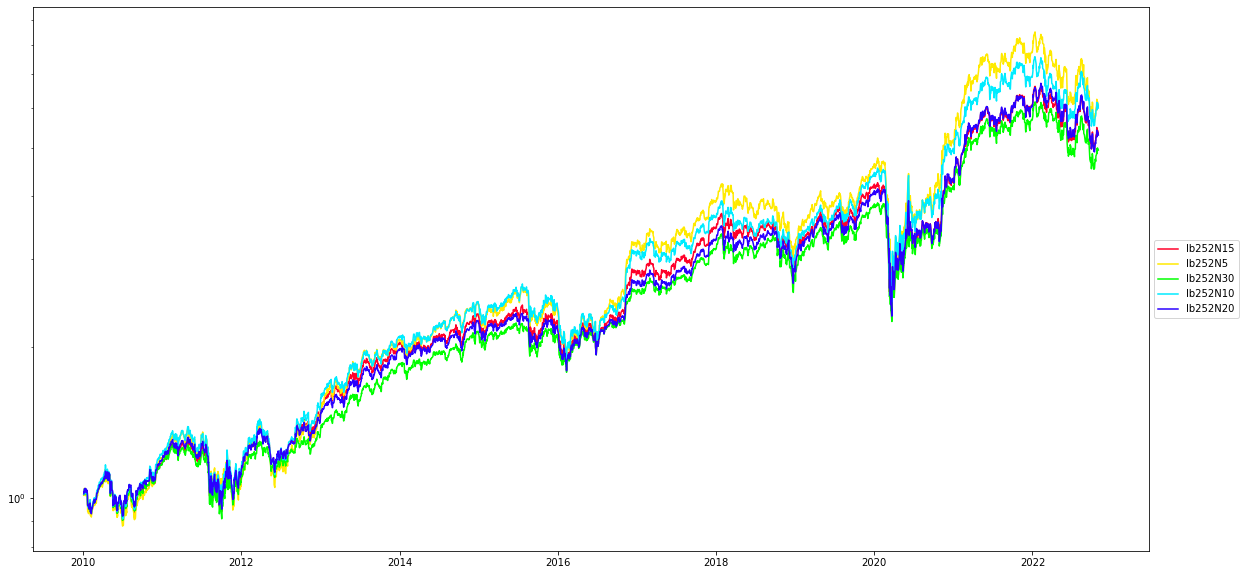

In [64]:
casestr = 'lb252'
casecols = list(set(cols + list(met.loc[met.index.str.contains(casestr), :].index)))
# display(met.loc[casecols, :].sort_values('Total Score', ascending=False))
display(met.loc[casecols, :].sort_values('sharpe_ratio', ascending=False))
# display(met.loc[casecols, :].sort_values('return/avgdd', ascending=False))
# display(met.loc[casecols, :].sort_values('annual_return', ascending=False))
show_cum_ret(returns.loc[:, casecols])

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score
case,,,,,,,,,,,,,
lb126N30,4.4719,0.141702,0.695404,0.228209,-0.424083,-0.056477,0.334138,2.509026,69.540412,107.085112,57.591742,94.352300,0.356547
lb10N30,3.5460,0.125319,0.682460,0.203531,-0.384413,-0.048021,0.326000,2.609686,68.246035,106.265938,61.558704,95.197937,0.375346
lb252N30,3.9480,0.132778,0.656691,0.230517,-0.420268,-0.058840,0.315937,2.256614,65.669096,106.638911,57.973217,94.116042,0.310362
lb50N30,3.3268,0.120991,0.621498,0.224588,-0.439979,-0.056703,0.274993,2.133784,62.149815,106.049549,56.002094,94.329746,0.245808


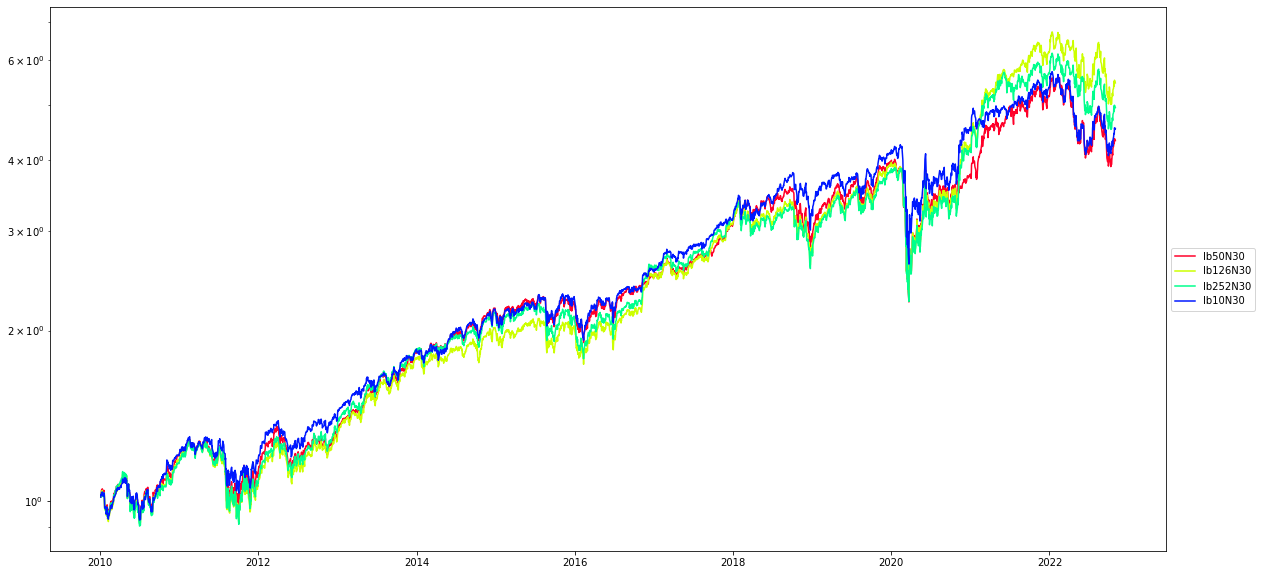

In [65]:
casestr = 'N30'
casecols = list(set(cols + list(met.loc[met.index.str.contains(casestr), :].index)))
# display(met.loc[casecols, :].sort_values('Total Score', ascending=False))
display(met.loc[casecols, :].sort_values('sharpe_ratio', ascending=False))
# display(met.loc[casecols, :].sort_values('return/avgdd', ascending=False))
# display(met.loc[casecols, :].sort_values('annual_return', ascending=False))
show_cum_ret(returns.loc[:, casecols])

lb10


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score
case,,,,,,,,,,,,,
lb10N10,3.5218,0.124851,0.636780,0.224586,-0.450545,-0.060130,0.277110,2.076353,63.677990,106.242527,54.945545,93.987028,0.250956
lb10N15,3.1188,0.116693,0.621344,0.215047,-0.423228,-0.058387,0.275722,1.998619,62.134413,105.834658,57.677217,94.161310,0.256423
lb252N30,3.9480,0.132778,0.656691,0.230517,-0.420268,-0.058840,0.315937,2.256614,65.669096,106.638911,57.973217,94.116042,0.310362
lb10N20,3.6312,0.126949,0.674938,0.209908,-0.400332,-0.051605,0.317110,2.460022,67.493828,106.347458,59.966800,94.839512,0.349951
lb10N5,3.4263,0.122980,0.604699,0.239557,-0.489858,-0.073423,0.251052,1.674956,60.469902,106.148997,51.014201,92.657722,0.164398
lb10N30,3.5460,0.125319,0.682460,0.203531,-0.384413,-0.048021,0.326000,2.609686,68.246035,106.265938,61.558704,95.197937,0.375346


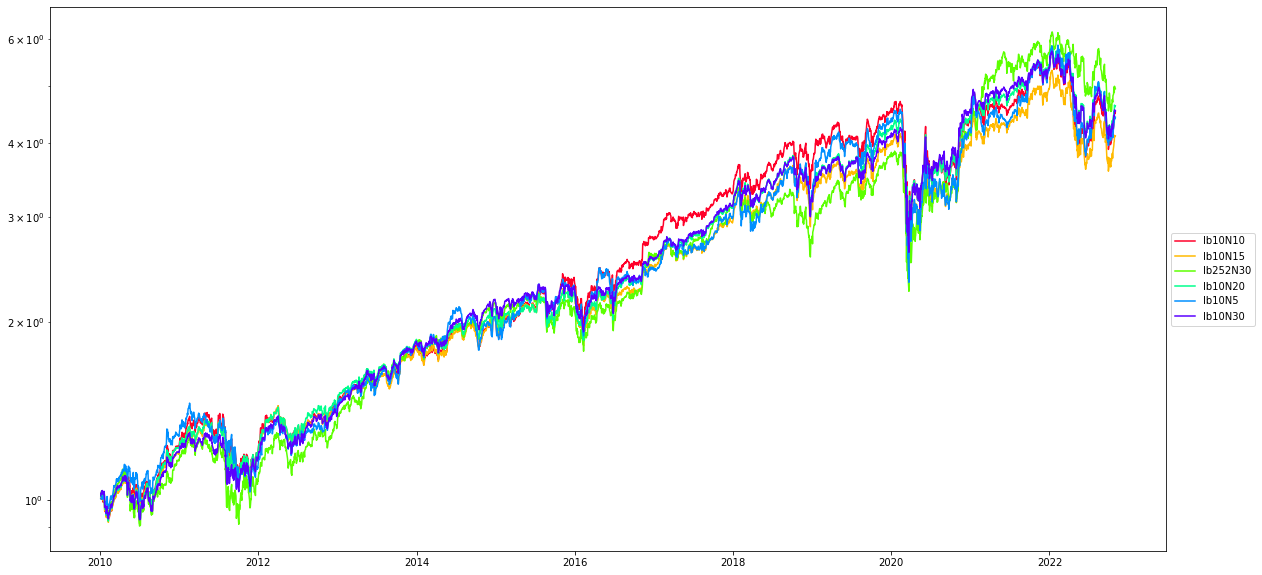

lb50


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score
case,,,,,,,,,,,,,
lb50N20,3.6644,0.127577,0.628237,0.235499,-0.442876,-0.061637,0.288065,2.069797,62.823664,106.378850,55.712361,93.836256,0.251300
lb50N15,4.5246,0.142556,0.668935,0.243939,-0.461583,-0.063053,0.308841,2.260886,66.893541,107.127790,53.841732,93.694694,0.286855
lb50N5,3.2730,0.119898,0.557289,0.267791,-0.479357,-0.084213,0.250122,1.423751,55.728892,105.994895,52.064263,91.578733,0.113617
lb252N30,3.9480,0.132778,0.656691,0.230517,-0.420268,-0.058840,0.315937,2.256614,65.669096,106.638911,57.973217,94.116042,0.310362
lb50N10,4.2031,0.137227,0.632419,0.254957,-0.466478,-0.068202,0.294177,2.012067,63.241890,106.861352,53.352181,93.179797,0.234966


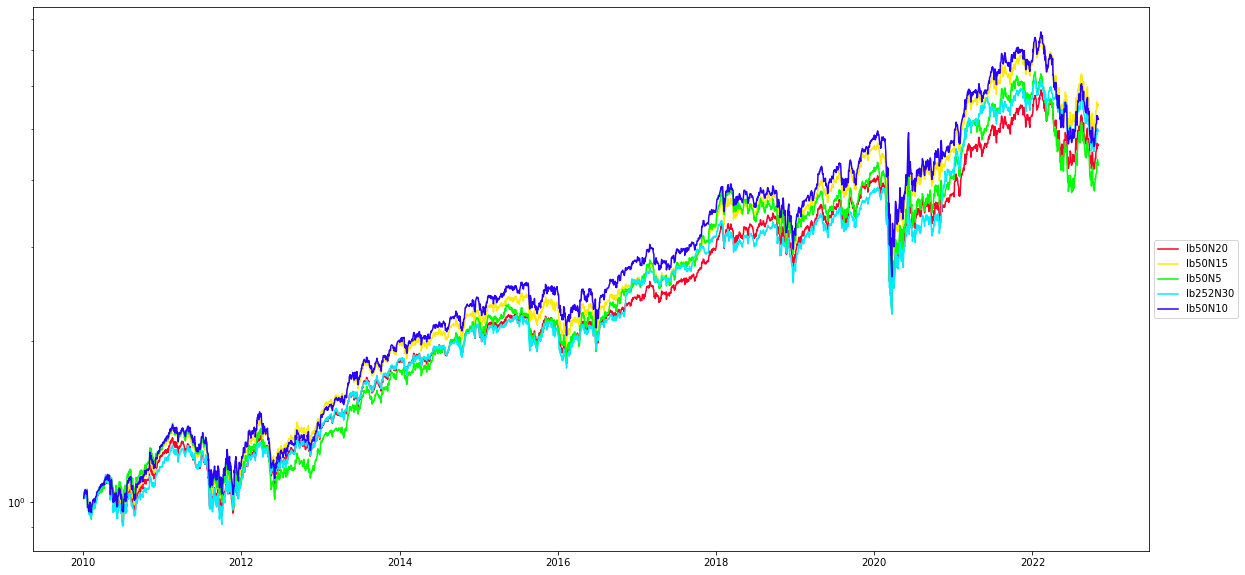

lb63
lb126


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score
case,,,,,,,,,,,,,
lb126N30,4.4719,0.141702,0.695404,0.228209,-0.424083,-0.056477,0.334138,2.509026,69.540412,107.085112,57.591742,94.352300,0.356547
lb252N30,3.9480,0.132778,0.656691,0.230517,-0.420268,-0.058840,0.315937,2.256614,65.669096,106.638911,57.973217,94.116042,0.310362


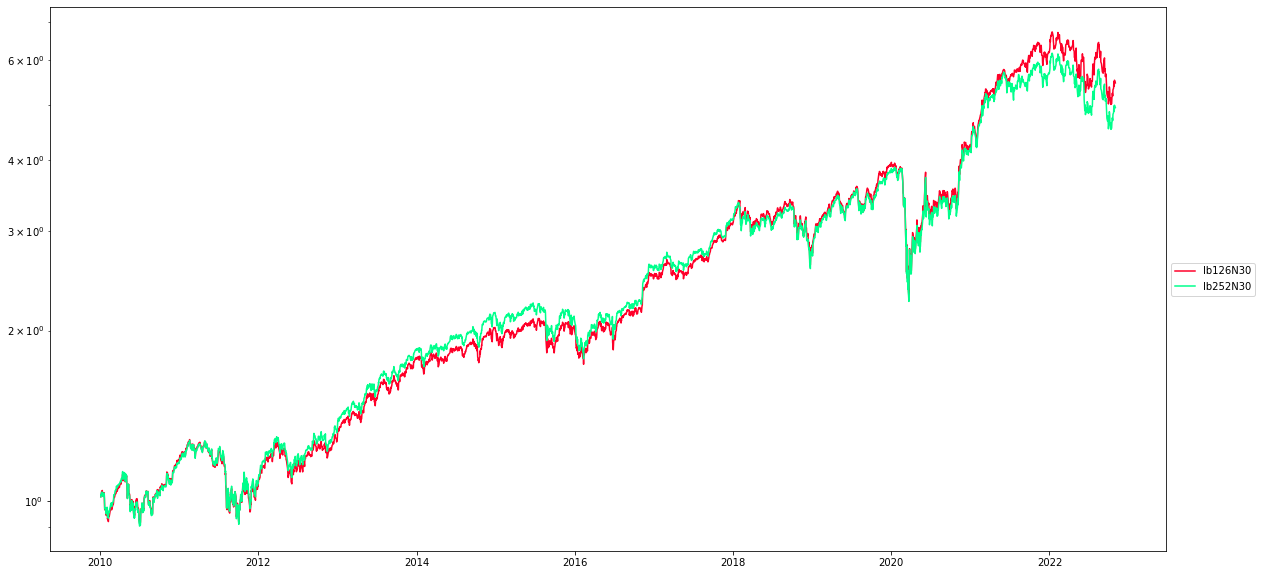

lb252


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score
case,,,,,,,,,,,,,
lb252N15,4.3089,0.139013,0.640806,0.253432,-0.463567,-0.069101,0.299878,2.011746,64.080630,106.950668,53.643302,93.089915,0.247152
lb252N5,5.0672,0.150932,0.641435,0.280720,-0.488462,-0.085455,0.308995,1.766217,64.143484,107.546622,51.153822,91.454478,0.218450
lb252N30,3.9480,0.132778,0.656691,0.230517,-0.420268,-0.058840,0.315937,2.256614,65.669096,106.638911,57.973217,94.116042,0.310362
lb252N10,4.9998,0.149930,0.659172,0.265670,-0.459591,-0.078471,0.326226,1.910654,65.917216,107.496520,54.040881,92.152928,0.271041
lb252N20,4.3021,0.138900,0.657095,0.243091,-0.442523,-0.061964,0.313881,2.241614,65.709476,106.944977,55.747723,93.803593,0.291507


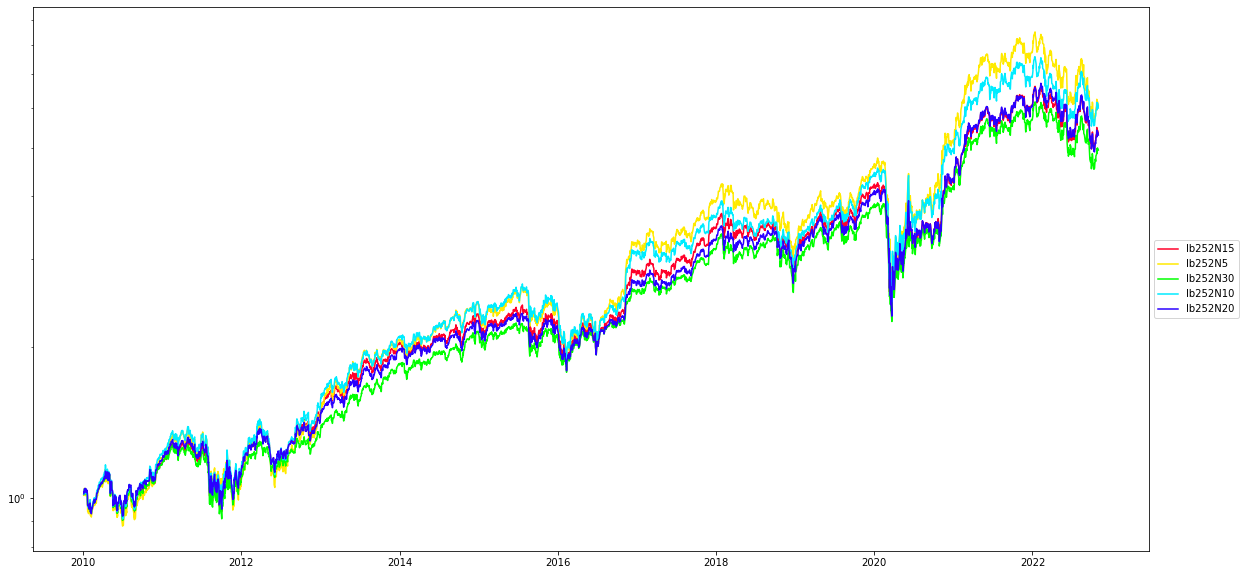

N5


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score
case,,,,,,,,,,,,,
lb10N5,3.4263,0.122980,0.604699,0.239557,-0.489858,-0.073423,0.251052,1.674956,60.469902,106.148997,51.014201,92.657722,0.164398
lb252N5,5.0672,0.150932,0.641435,0.280720,-0.488462,-0.085455,0.308995,1.766217,64.143484,107.546622,51.153822,91.454478,0.218450
lb252N30,3.9480,0.132778,0.656691,0.230517,-0.420268,-0.058840,0.315937,2.256614,65.669096,106.638911,57.973217,94.116042,0.310362
lb50N5,3.2730,0.119898,0.557289,0.267791,-0.479357,-0.084213,0.250122,1.423751,55.728892,105.994895,52.064263,91.578733,0.113617


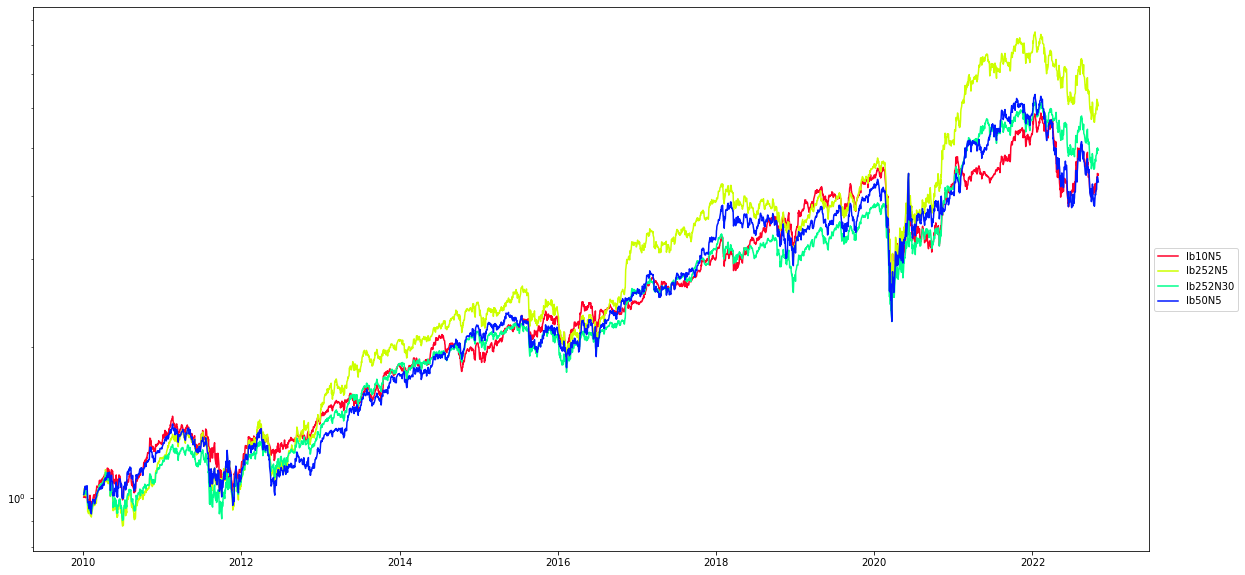

N10


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score
case,,,,,,,,,,,,,
lb252N10,4.9998,0.149930,0.659172,0.265670,-0.459591,-0.078471,0.326226,1.910654,65.917216,107.496520,54.040881,92.152928,0.271041
lb50N10,4.2031,0.137227,0.632419,0.254957,-0.466478,-0.068202,0.294177,2.012067,63.241890,106.861352,53.352181,93.179797,0.234966
lb252N30,3.9480,0.132778,0.656691,0.230517,-0.420268,-0.058840,0.315937,2.256614,65.669096,106.638911,57.973217,94.116042,0.310362
lb10N10,3.5218,0.124851,0.636780,0.224586,-0.450545,-0.060130,0.277110,2.076353,63.677990,106.242527,54.945545,93.987028,0.250956


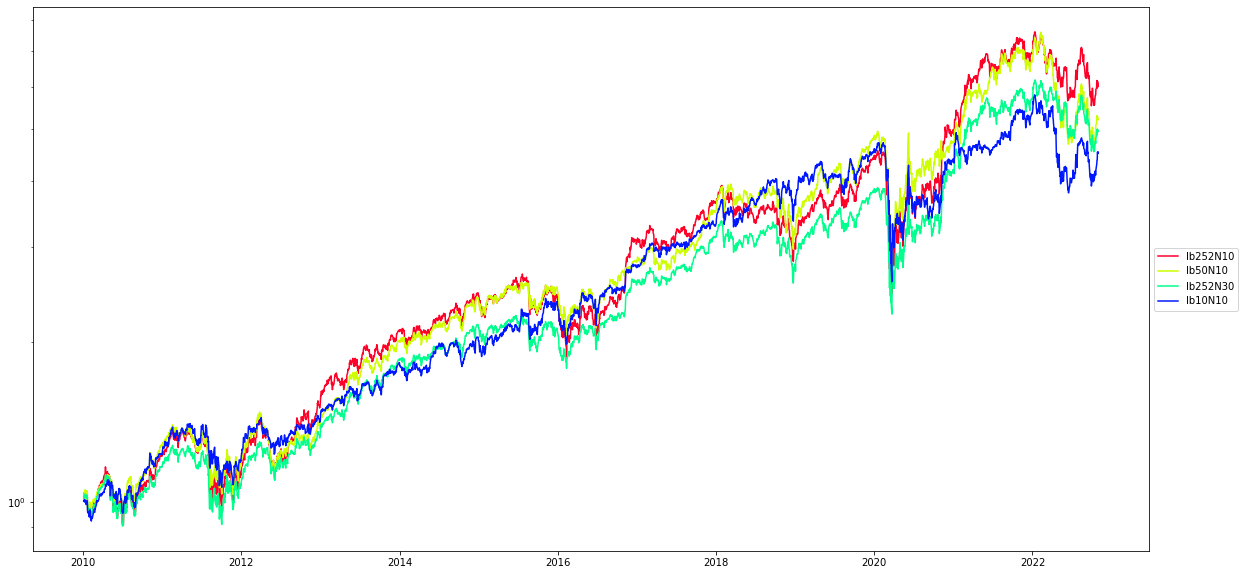

N15


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score
case,,,,,,,,,,,,,
lb252N15,4.3089,0.139013,0.640806,0.253432,-0.463567,-0.069101,0.299878,2.011746,64.080630,106.950668,53.643302,93.089915,0.247152
lb10N15,3.1188,0.116693,0.621344,0.215047,-0.423228,-0.058387,0.275722,1.998619,62.134413,105.834658,57.677217,94.161310,0.256423
lb252N30,3.9480,0.132778,0.656691,0.230517,-0.420268,-0.058840,0.315937,2.256614,65.669096,106.638911,57.973217,94.116042,0.310362
lb50N15,4.5246,0.142556,0.668935,0.243939,-0.461583,-0.063053,0.308841,2.260886,66.893541,107.127790,53.841732,93.694694,0.286855


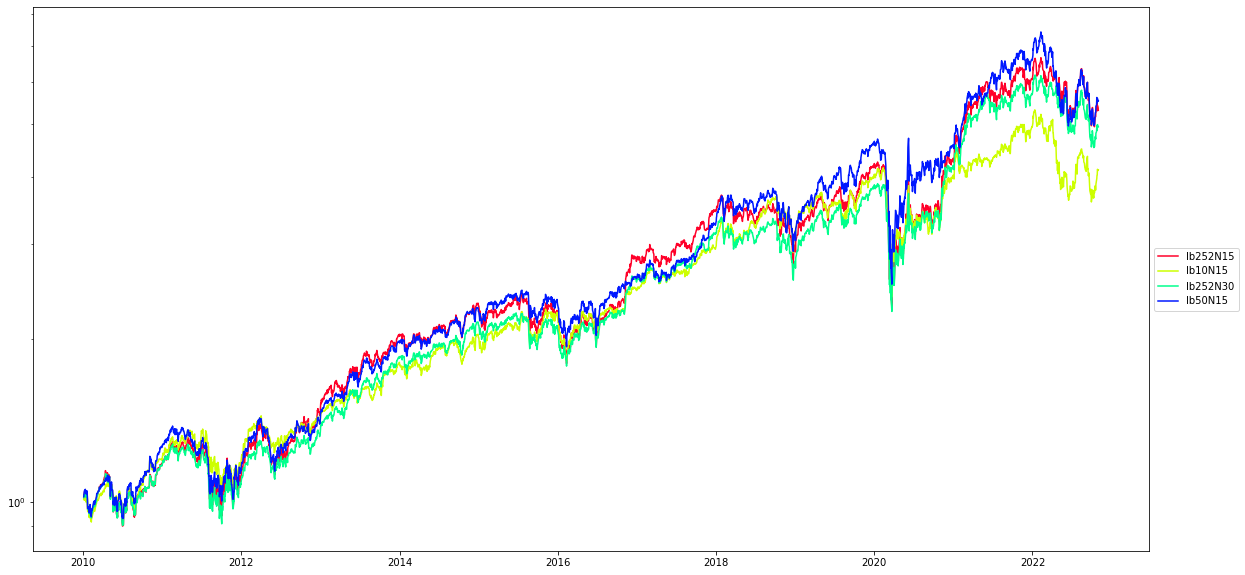

N20


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score
case,,,,,,,,,,,,,
lb50N20,3.6644,0.127577,0.628237,0.235499,-0.442876,-0.061637,0.288065,2.069797,62.823664,106.378850,55.712361,93.836256,0.251300
lb252N20,4.3021,0.138900,0.657095,0.243091,-0.442523,-0.061964,0.313881,2.241614,65.709476,106.944977,55.747723,93.803593,0.291507
lb252N30,3.9480,0.132778,0.656691,0.230517,-0.420268,-0.058840,0.315937,2.256614,65.669096,106.638911,57.973217,94.116042,0.310362
lb10N20,3.6312,0.126949,0.674938,0.209908,-0.400332,-0.051605,0.317110,2.460022,67.493828,106.347458,59.966800,94.839512,0.349951


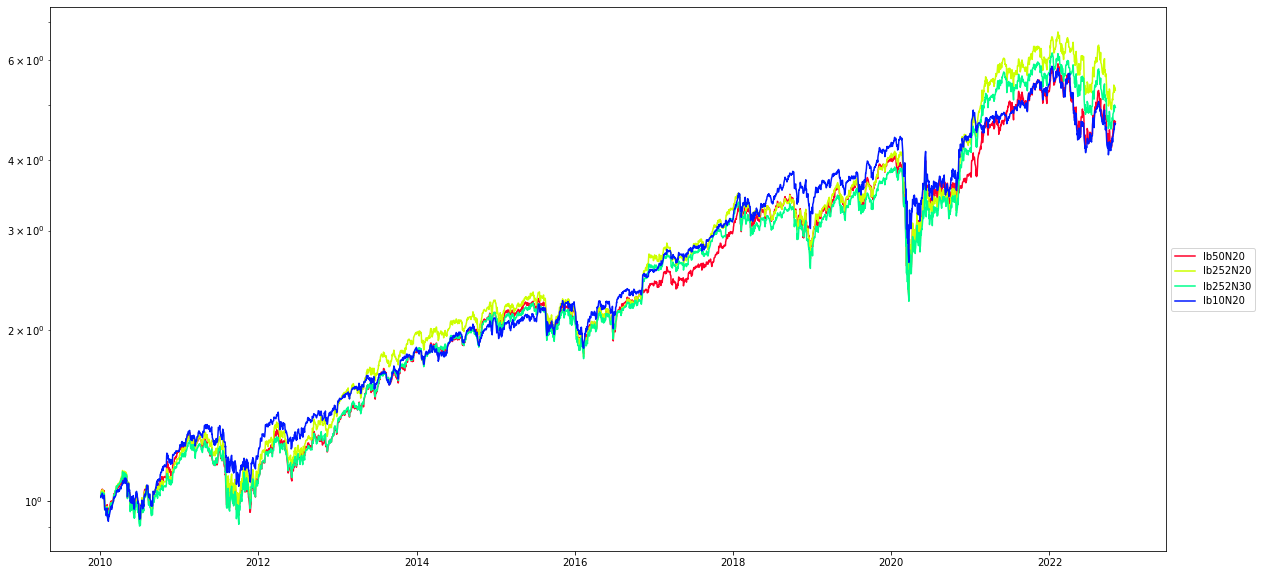

N30


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score
case,,,,,,,,,,,,,
lb126N30,4.4719,0.141702,0.695404,0.228209,-0.424083,-0.056477,0.334138,2.509026,69.540412,107.085112,57.591742,94.352300,0.356547
lb252N30,3.9480,0.132778,0.656691,0.230517,-0.420268,-0.058840,0.315937,2.256614,65.669096,106.638911,57.973217,94.116042,0.310362
lb10N30,3.5460,0.125319,0.682460,0.203531,-0.384413,-0.048021,0.326000,2.609686,68.246035,106.265938,61.558704,95.197937,0.375346


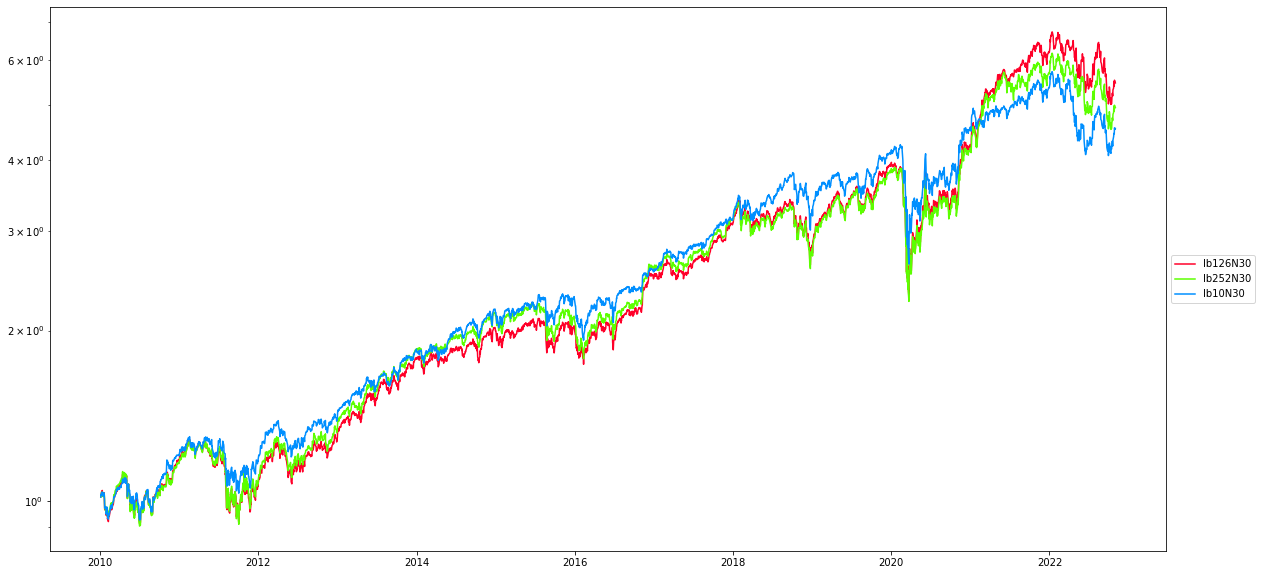

In [56]:

for para, opts in case_dict.items():
    for num in opts:
        print("========================================")
        casestr = para + str(num)
        print(casestr)
        casecols = list(set(cols + list(met.loc[met.index.str.contains(casestr), :].index)))
        if len(casecols) == len(cols):
            continue
        # print(casecols)
        display(met.loc[casecols, :])
        show_cum_ret(returns.loc[:, casecols])